In [1]:
import pandas as pd
import scipy as sp

from abtools.bayesian import WaldABModel, LognormalABModel

%matplotlib inline

In [6]:
mu = 9
size = 10000
delta_true = .015

arppu_a = pd.Series(sp.stats.wald.rvs(loc=mu, size=size, random_state=8228))
arppu_b = pd.Series(sp.stats.wald.rvs(loc=mu * (1 + delta_true), size=size, random_state=8228))

print('ARPPU')
print('Mean: %.4f' % arppu_a.mean())
print('Mean: %.4f' % arppu_b.mean())
print('B больше A на %.4f = %d%%' % (arppu_b.mean()- arppu_a.mean(), 
                                    (arppu_b.mean() / arppu_a.mean()-1)*100))

ARPPU
Mean: 9.9941
Mean: 10.1291
B больше A на 0.1350 = 1%


In [7]:
model = WaldABModel(arppu_a, arppu_b)

In [8]:
model.fit()

Optimization terminated successfully.
         Current function value: 54303.783620
         Iterations: 33
         Function evaluations: 39
         Gradient evaluations: 39

100%|██████████| 10000/10000 [00:06<00:00, 1665.21it/s]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c9e75fb00>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1c9e224278>], dtype=object)

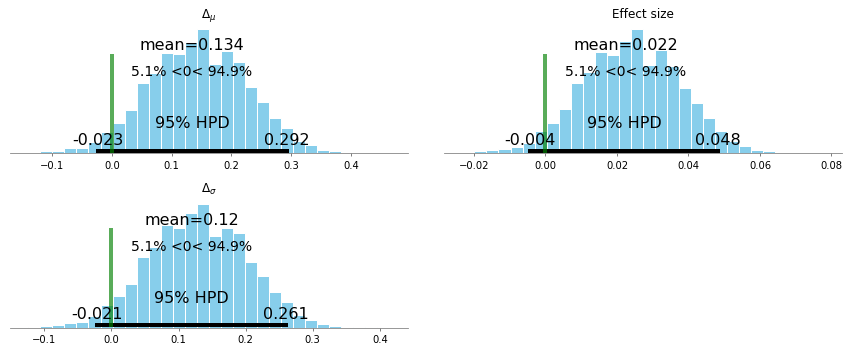

In [9]:
model.plot_deltas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c9cef9780>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1c9cd9da20>], dtype=object)

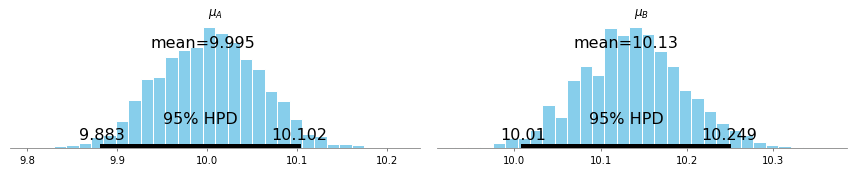

In [11]:
model.plot_params()

In [12]:
model = LognormalABModel(arppu_a, arppu_b)
model.fit()

         Current function value: 52677.716489
         Iterations: 33


100%|██████████| 10000/10000 [00:05<00:00, 1864.33it/s]

         Function evaluations: 111
         Gradient evaluations: 100


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c93786a58>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1c933646d8>], dtype=object)

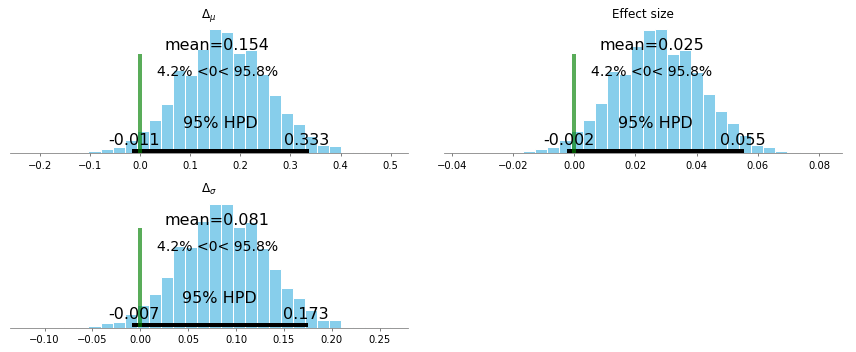

In [13]:
model.plot_deltas()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c93860198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1c943f3208>], dtype=object)

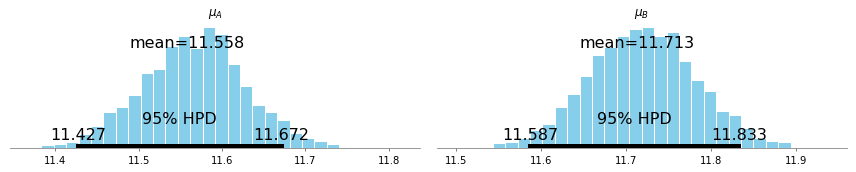

In [14]:
model.plot_params()

In [15]:
model.summary()

,mean,sd,mc_error,hpd_2.5,hpd_97.5
$\lambda_A$,3.344968,0.000701,0.000016,3.343576,3.345654
$\mu_{ln(A)}$,2.297924,0.005424,0.000144,2.287385,2.308588
$\lambda_B$,3.344954,0.000700,0.000015,3.343540,3.345654
$\mu_{ln(B)}$,2.311181,0.005412,0.000119,2.300406,2.321369
$\mu_A$,11.558448,0.062706,0.001664,11.426763,11.671621
$\mu_B$,11.712712,0.063399,0.001398,11.587194,11.832801
$A_{\sigma^2}$,36.448706,0.395372,0.010492,35.622683,37.166554
$B_{\sigma^2}$,37.428076,0.405254,0.008939,36.627953,38.196250
$\Delta_{\mu}$,0.154265,0.088573,0.002316,-0.011400,0.332768
$\Delta_{\sigma}$,0.080572,0.046261,0.001209,-0.006971,0.172819
